In [ ]:
import warnings
warnings.simplefilter('ignore')

# Load Data

In [2]:
import pandas as pd, numpy as np, gc

train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')
orig = pd.read_csv('/kaggle/input/exam-score-prediction-dataset/Exam_Score_Prediction.csv')
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)
print('Orig Shape:', orig.shape)

train.head(3)

Train Shape: (630000, 13)
Test Shape: (270000, 12)
Orig Shape: (20000, 13)


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0


In [3]:
TARGET = 'exam_score'
BASE = [col for col in train.columns if col not in ['id', TARGET]]
CATS = train.select_dtypes('object').columns.to_list()
NUMS = [col for col in BASE if col not in CATS]
print(f'{len(BASE)} Base Features:{BASE}')

11 Base Features:['age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


# Some EDA for Modeling

## 1. Check Unique Values & Missing Data
First, let's check the number of unique values and missing values for both **NUMS** and **CATS** features.

In [4]:
print('NaN Count:', train[CATS].isnull().sum().sum(), '\n')
print(train[CATS].nunique(),'\n')
train[CATS].head(3)

NaN Count: 0 

gender             3
course             7
internet_access    2
sleep_quality      3
study_method       5
facility_rating    3
exam_difficulty    3
dtype: int64 



,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
0,female,b.sc,no,average,online videos,low,easy
1,other,diploma,yes,poor,self-study,medium,moderate
2,female,b.sc,yes,poor,coaching,high,moderate


In [5]:
print('NaN Count:', train[NUMS].isnull().sum().sum(), '\n')
print(train[NUMS].nunique(),'\n')
train[NUMS].head(3)

NaN Count: 0 

age                   8
study_hours         792
class_attendance    617
sleep_hours          66
dtype: int64 



,age,study_hours,class_attendance,sleep_hours
0,21,7.91,98.8,4.9
1,18,4.95,94.8,4.7
2,20,4.68,92.6,5.8


### Observations
* **No Missing Values:** The dataset is clean, containing zero null values.
* **Low Cardinality:** Even the numerical features exhibit relatively low unique counts (cardinality) considering the large dataset size of roughly 700k samples.
* **Feature Engineering Idea:** Given this discrete nature, **Target Encoding** could be effective in extracting more signals from Numerical features.

## 2.1 Target Distribution
Target distribution for exam scores.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

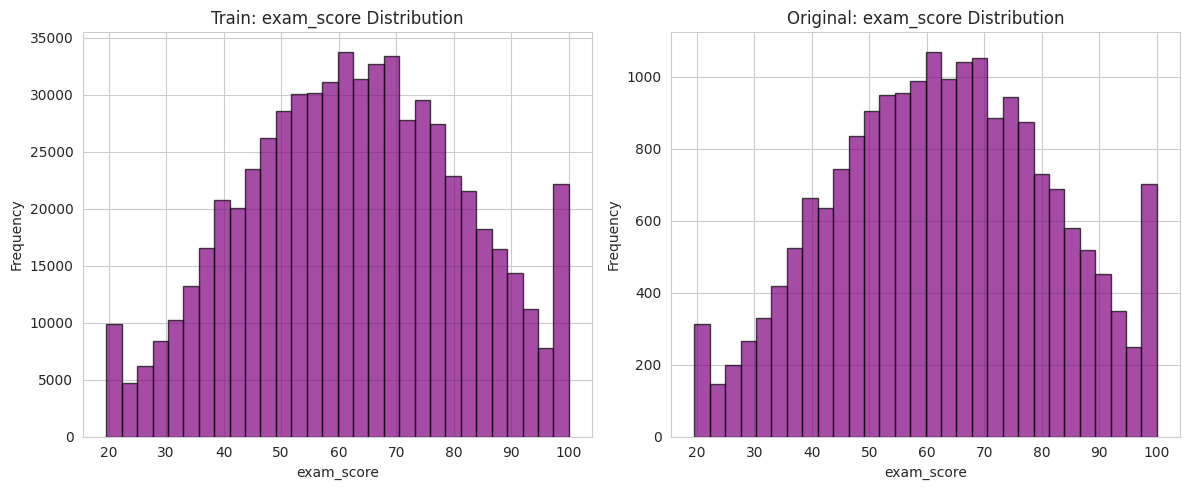

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(train[TARGET], bins=30, color='purple', edgecolor='black', alpha=0.7)
ax[0].set_title(f'Train: {TARGET} Distribution')
ax[0].set_xlabel(TARGET)
ax[0].set_ylabel('Frequency')

if TARGET in orig.columns:
    ax[1].hist(orig[TARGET], bins=30, color='purple', edgecolor='black', alpha=0.7)
    ax[1].set_title(f'Original: {TARGET} Distribution')
    ax[1].set_xlabel(TARGET)
    ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## 2.2 Feature Distributions (Train vs Test vs Original)
Next, we visualize the distributions of numerical features across the Train, Test, and Original datasets. It is crucial to confirm that the Test set follows a similar distribution to the Train set to ensure model generalization.

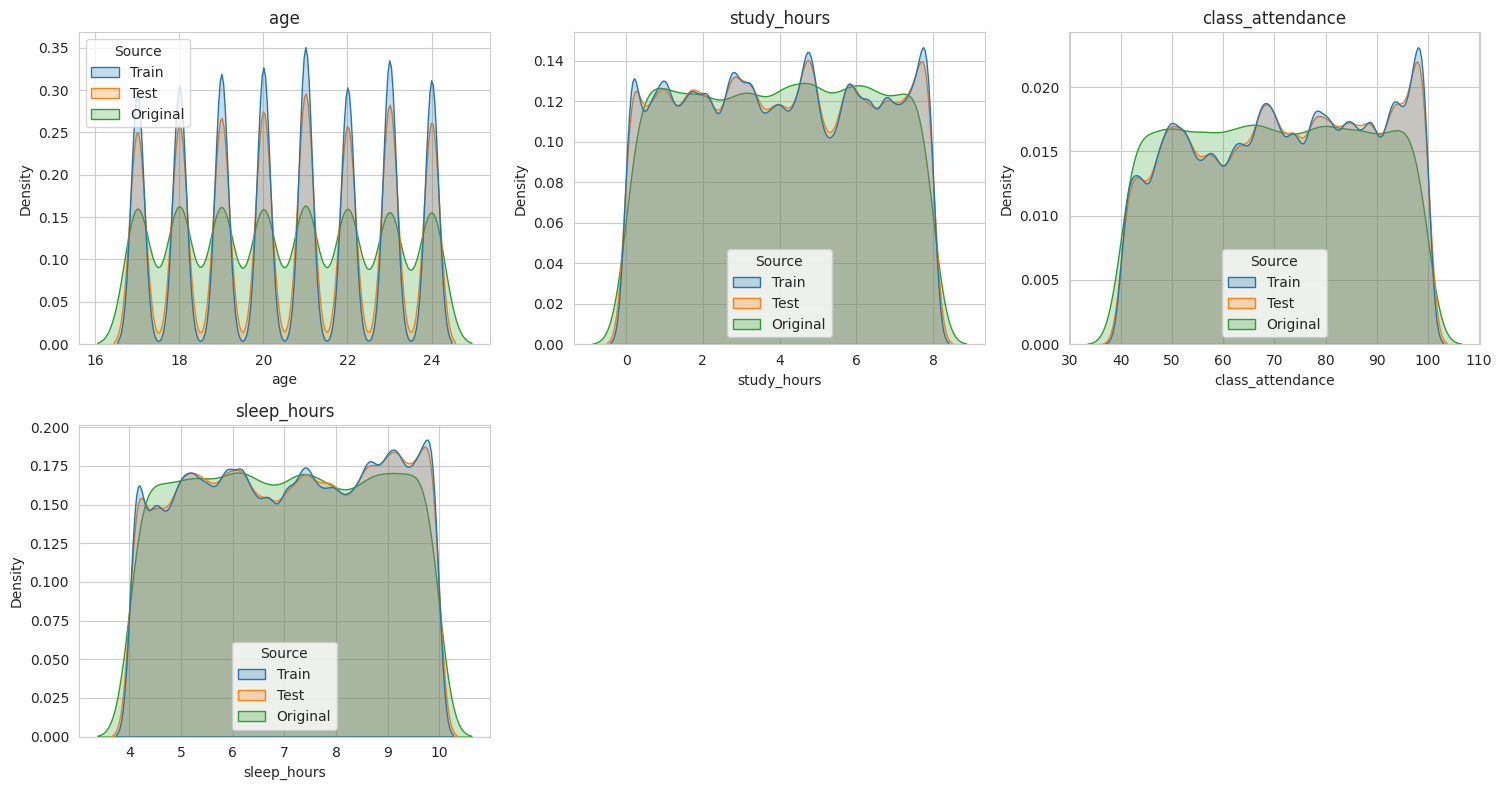

In [8]:
df_plot = pd.concat([
    train[NUMS].assign(Source='Train'),
    test[NUMS].assign(Source='Test'),
    orig[NUMS].assign(Source='Original')
])

n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    sns.kdeplot(data=df_plot, x=col, hue='Source', ax=axes[i], 
                fill=True, common_norm=False, warn_singular=False)
    axes[i].set_title(col)

for i in range(len(NUMS), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

del df_plot

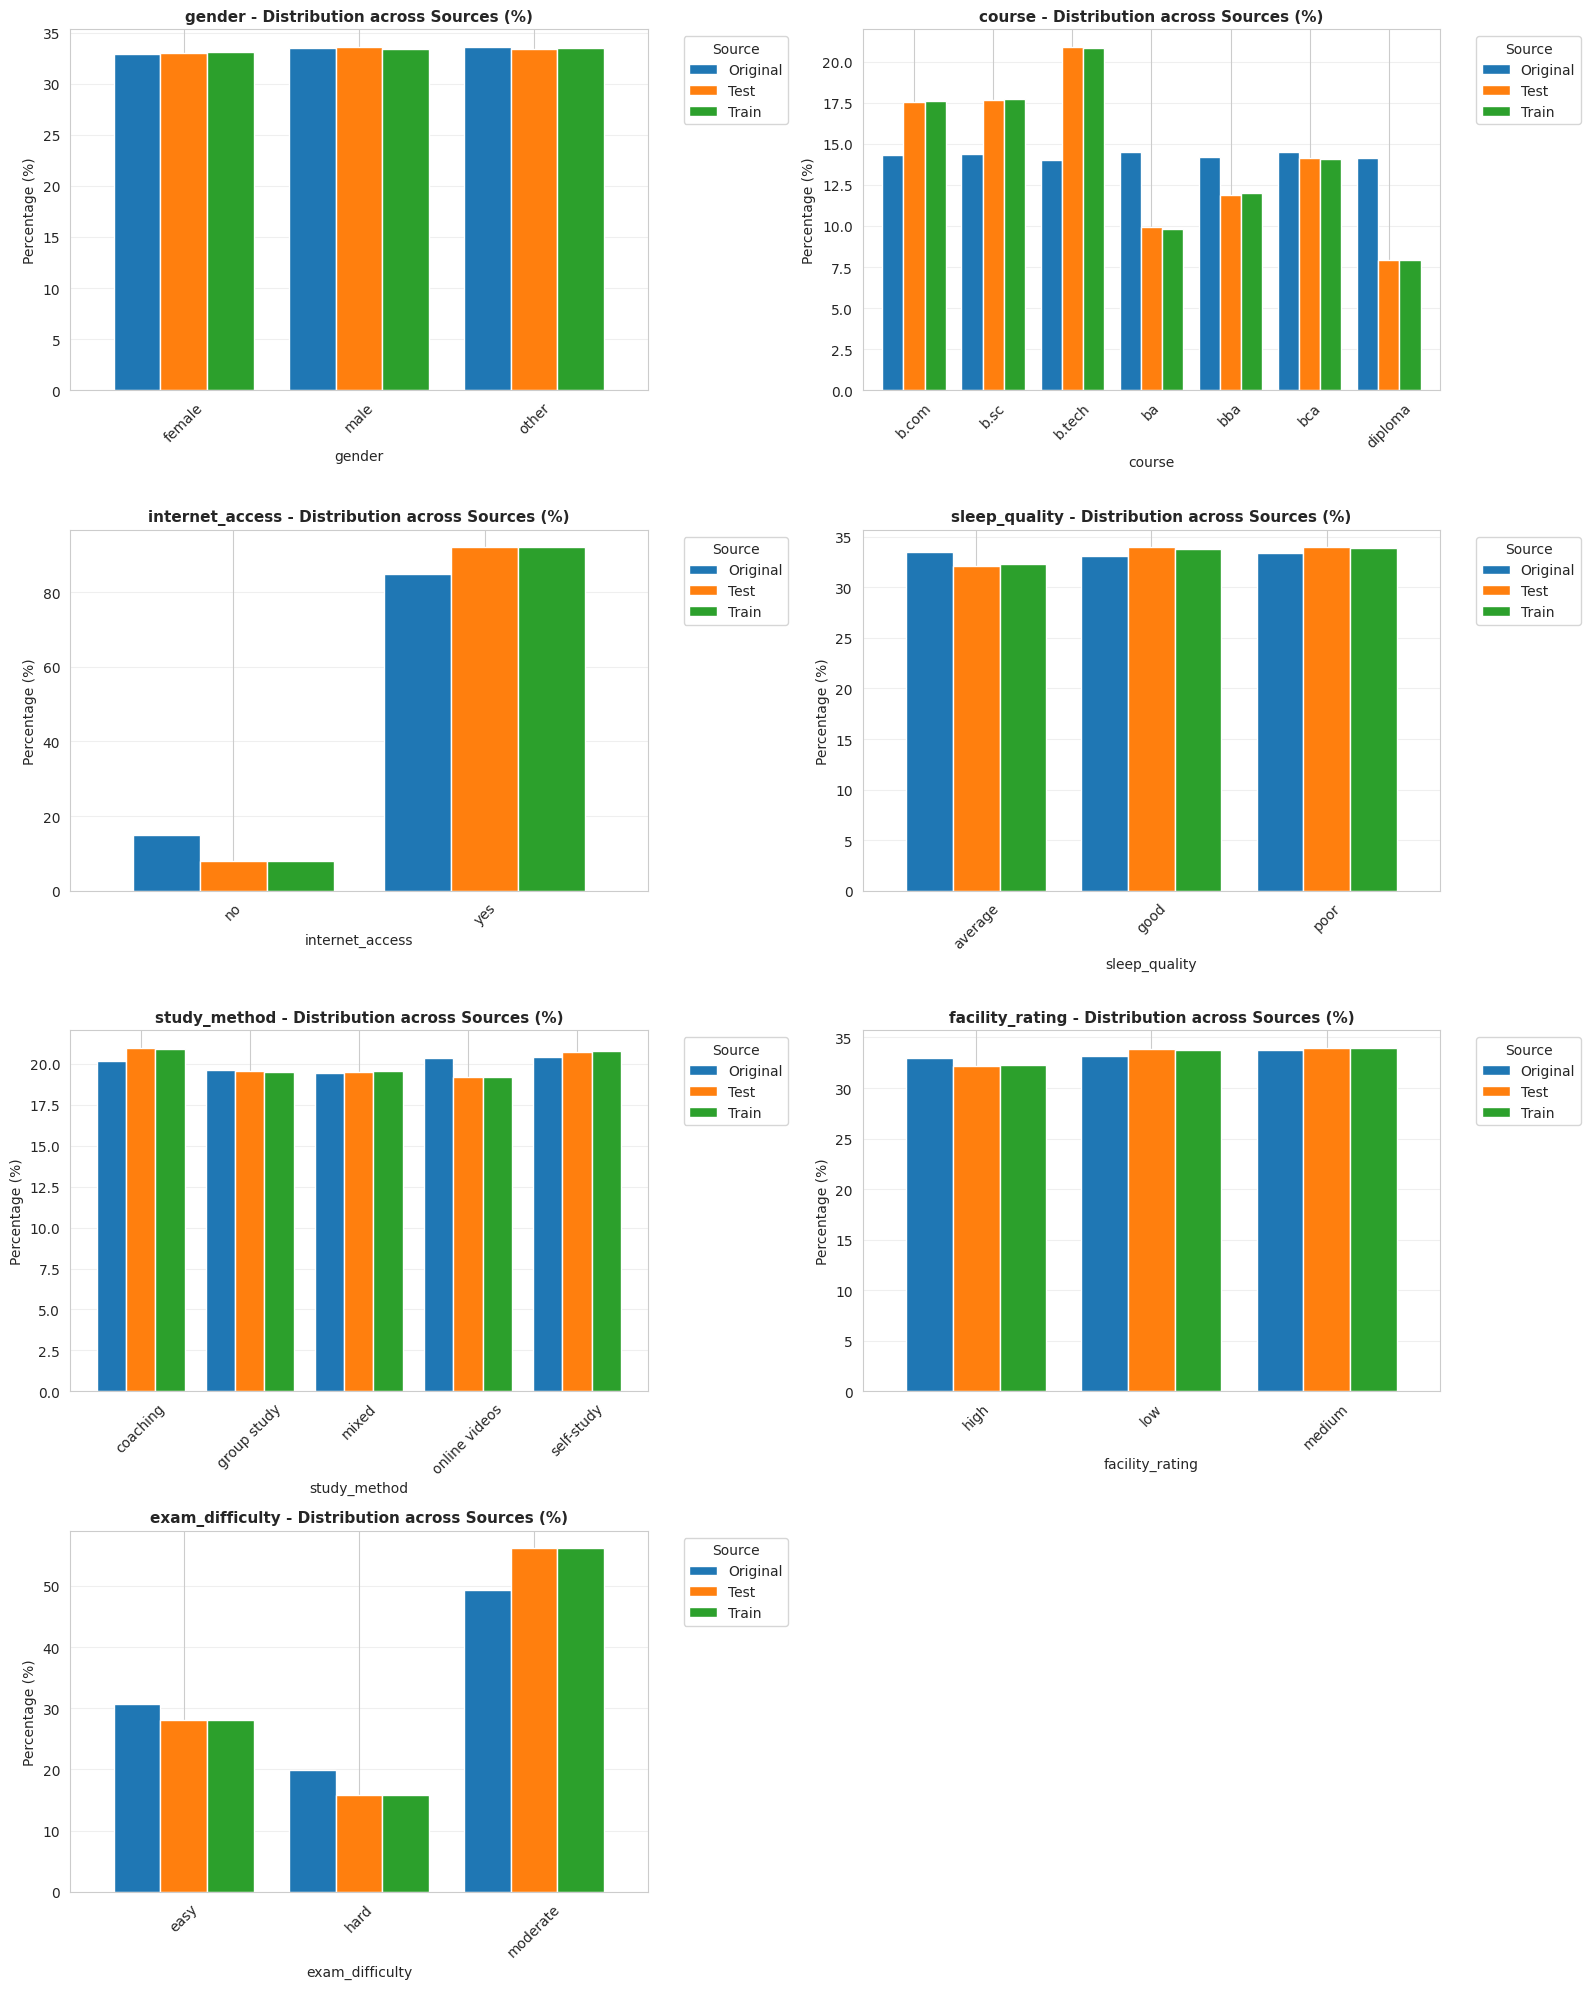

In [9]:
if len(CATS) > 0:
    df_plot_cats = pd.concat([
        train[CATS].assign(Source='Train'),
        test[CATS].assign(Source='Test'),
        orig[CATS].assign(Source='Original')
    ])

    n_cols = 2
    n_rows = (len(CATS) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(CATS):
        ct = pd.crosstab(df_plot_cats[col], df_plot_cats['Source'])
        ct_normalized = ct.div(ct.sum(axis=0), axis=1) * 100
        ct_normalized.plot(kind='bar', stacked=False, ax=axes[i], width=0.8)
        axes[i].set_title(f'{col} - Distribution across Sources (%)', fontsize=11, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Percentage (%)')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].grid(axis='y', alpha=0.3)

    for i in range(len(CATS), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    del df_plot_cats, ct, ct_normalized

## 2.3 Correlation Matrix
Finally, we analyze the correlation between numerical features and the target. This heatmap helps identify multicollinearity and highlights features that have a strong linear relationship with the target.

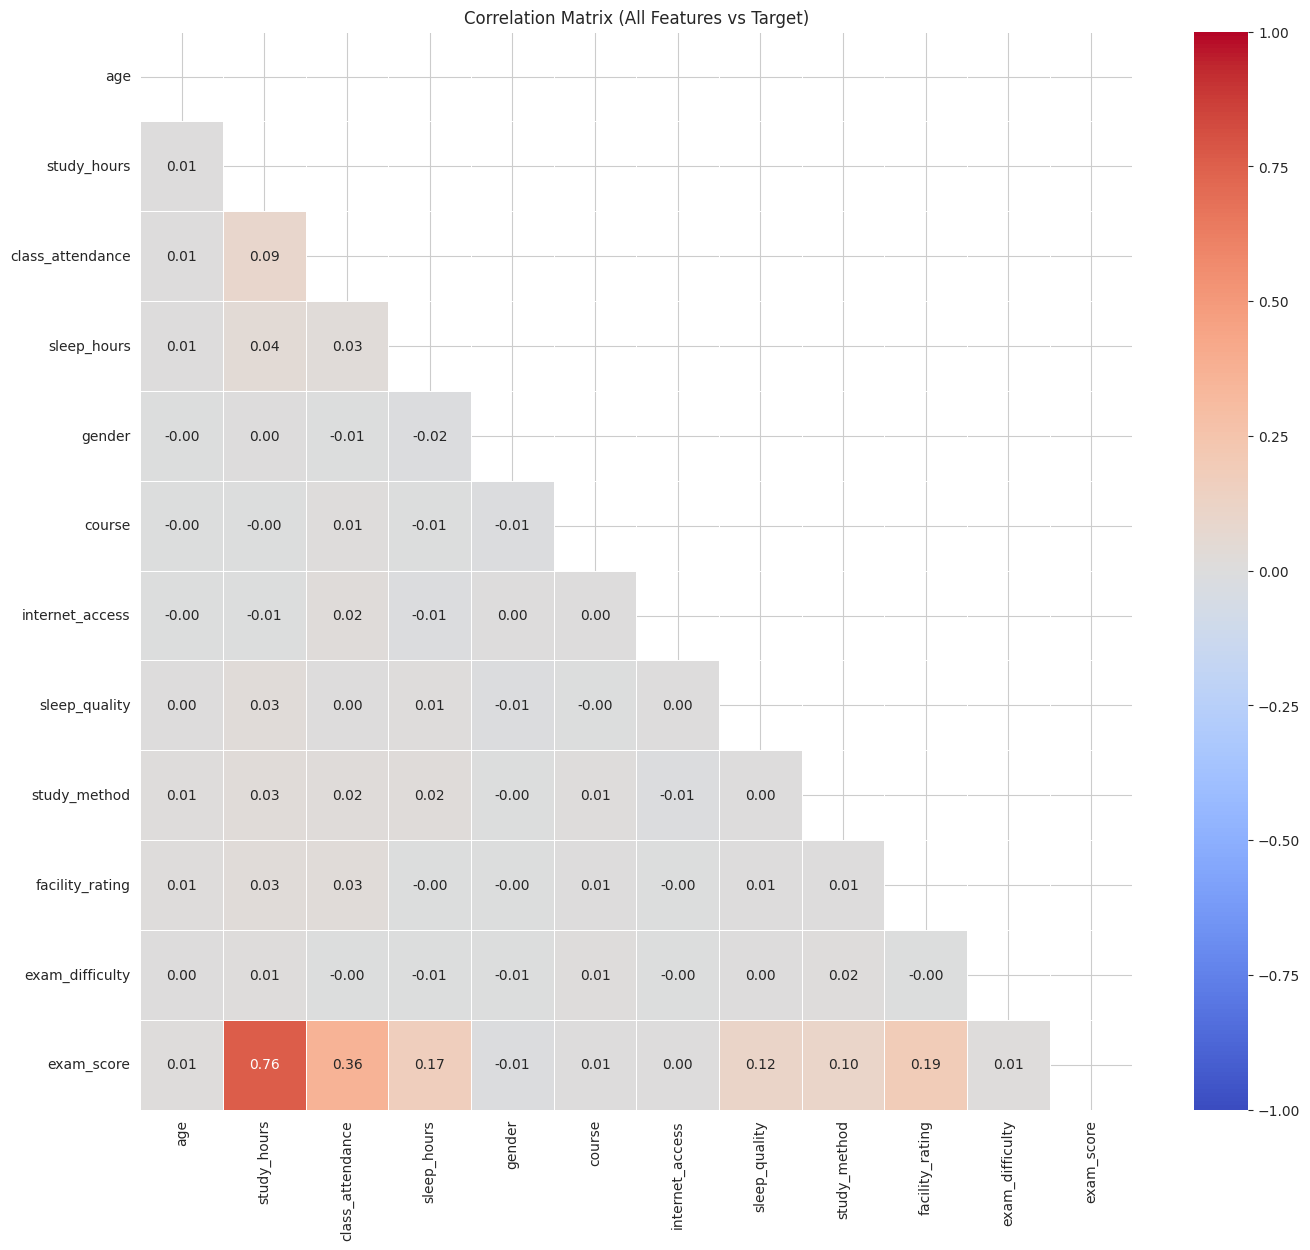

In [10]:
temp_corr_df = train[NUMS + CATS + [TARGET]].copy()

for col in CATS:
    temp_corr_df[col] = pd.factorize(temp_corr_df[col])[0]

corr_matrix = temp_corr_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix (All Features vs Target)')
plt.show()

### Observations & Strategy
Feature distributions across datasets show alignment between Train and Test sets.

# 3. Feature Engineering
## Techniques from Winning Solution (pg-s5e11):
# 1. Digit extraction - captures synthetic data patterns
# 2. Quantile binning - discretizes numerical features  
# 3. Feature rounding
# 4. Pairwise/triplet feature combinations
# 5. External encoding from original dataset

In [ ]:
from itertools import combinations
from tqdm import tqdm

# Safety check: Ensure no duplicate column names (this is the most common cause)
if train.columns.duplicated().any():
    print("Warning: Duplicate columns found. Dropping duplicates...")
    train = train.loc[:, ~train.columns.duplicated()]
    test = test.loc[:, ~test.columns.duplicated()]
    orig = orig.loc[:, ~orig.columns.duplicated()]

# Ensure indices are unique (if duplicates exist, make them unique)
if train.index.duplicated().any():
    print("Warning: Duplicate indices found in train. Making unique...")
    train.index = pd.RangeIndex(len(train))
if test.index.duplicated().any():
    print("Warning: Duplicate indices found in test. Making unique...")
    test.index = pd.RangeIndex(len(test))

# =====================================================
# 3.1 DIGIT EXTRACTION (Key Winning Technique!)
# Extracts individual digits from numerical values
# This captures patterns in synthetic data generation
# =====================================================
DIGITS = []

for c in ['study_hours', 'class_attendance', 'sleep_hours']:
    for k in range(-2, 2):  # Different digit positions
        n = f'{c}_d{k}'
        train[n] = ((train[c] * 10**k) % 10).fillna(-1).astype("int8")
        test[n] = ((test[c] * 10**k) % 10).fillna(-1).astype("int8")
        orig[n] = ((orig[c] * 10**k) % 10).fillna(-1).astype("int8")
        DIGITS.append(n)

print(f"Created {len(DIGITS)} DIGIT features: {DIGITS[:6]}...")

# =====================================================
# 3.2 QUANTILE BINNING
# Discretizes numerical features into quantile bins
# =====================================================
BINS = []

# Drop existing bin features if they exist (prevents duplicate column error)
bin_cols_to_drop = [col for col in train.columns if col.endswith('_bin5') or col.endswith('_bin10')]
if bin_cols_to_drop:
    train = train.drop(columns=bin_cols_to_drop)
    test = test.drop(columns=[col for col in bin_cols_to_drop if col in test.columns])
    orig = orig.drop(columns=[col for col in bin_cols_to_drop if col in orig.columns])

bin_features_train = pd.DataFrame(index=train.index)
bin_features_test = pd.DataFrame(index=test.index)
bin_features_orig = pd.DataFrame(index=orig.index)

for c in NUMS:
    for q in [5, 10]:  # Different number of bins
        n = f"{c}_bin{q}"
        # Skip if already exists (safety check)
        if n in bin_features_train.columns:
            continue
        try:
            train_bins, bins = pd.qcut(train[c], q=q, labels=False, retbins=True, duplicates="drop")
            bin_features_train[n] = train_bins
            bin_features_test[n] = pd.cut(test[c], bins=bins, labels=False, include_lowest=True)
            # Also create bin features for orig (needed for pairs creation)
            bin_features_orig[n] = pd.cut(orig[c], bins=bins, labels=False, include_lowest=True)
            BINS.append(n)
        except Exception:
            # If binning fails (e.g., too few unique values), create feature with 0
            # This matches the winning solution approach
            bin_features_train[n] = 0
            bin_features_test[n] = 0
            bin_features_orig[n] = 0
            BINS.append(n)

# Only concatenate if there are new features to add
if len(bin_features_train.columns) > 0:
    train = pd.concat([train, bin_features_train], axis=1)
    test = pd.concat([test, bin_features_test], axis=1)
    orig = pd.concat([orig, bin_features_orig], axis=1)

print(f"Created {len(BINS)} BIN features: {BINS}")

# =====================================================
# 3.3 FEATURE ROUNDING
# Creates features by rounding to different precisions
# =====================================================
ROUND = []
RR = [-1, 0, 1]

for c in ['study_hours', 'class_attendance', 'sleep_hours']:
    for r in RR:
        n = f"{c}_r{r}"
        train[n] = train[c].round(r)
        test[n] = test[c].round(r)
        orig[n] = orig[c].round(r)
        ROUND.append(n)

print(f"Created {len(ROUND)} ROUND features: {ROUND}")

# =====================================================
# 3.4 PAIRWISE FEATURE COMBINATIONS  
# Creates interaction features between categorical vars
# =====================================================
PAIRS = []

# Only use BINS that actually exist in the dataframe (fix for KeyError)
BINS_EXISTING = [b for b in BINS if b in train.columns]
columns_for_pairs = CATS + BINS_EXISTING[:4]  # Combine cats with binned features

for r in [2]:  # Pairs
    for cols in tqdm(list(combinations(columns_for_pairs, r)), desc="Creating pairs"):
        # Double-check that both columns exist in all dataframes
        if (cols[0] not in train.columns or cols[1] not in train.columns or
            cols[0] not in orig.columns or cols[1] not in orig.columns):
            continue
            
        name = '-'.join(cols)
        
        train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
        test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)
        orig[name] = orig[cols[0]].astype(str) + '_' + orig[cols[1]].astype(str)
        
        combined = pd.concat([train[name], test[name], orig[name]], ignore_index=True)
        combined_encoded, _ = combined.factorize()
        
        # Filter out high cardinality combinations (>50% unique)
        if pd.Series(combined_encoded).nunique() > len(combined_encoded) // 2:
            train = train.drop(name, axis=1)
            test = test.drop(name, axis=1)
            orig = orig.drop(name, axis=1)
            continue
            
        train[name] = combined_encoded[:len(train)]
        test[name] = combined_encoded[len(train):len(train) + len(test)]
        orig[name] = combined_encoded[len(train) + len(test):]
        PAIRS.append(name)

print(f"Created {len(PAIRS)} PAIR features")

In [ ]:
# =====================================================
# 3.5 ORIGINAL DATASET ENCODING (Target + Count)
# Uses external original dataset for encoding
# =====================================================
ORIG = []

# Drop existing ORIG features if they exist (prevents duplicate column error)
orig_cols_to_drop = [col for col in train.columns if col.startswith('orig_')]
if orig_cols_to_drop:
    train = train.drop(columns=orig_cols_to_drop)
    test = test.drop(columns=[col for col in orig_cols_to_drop if col in test.columns])

# Encode BASE features
for col in BASE:
    # MEAN target encoding from original
    mean_map = orig.groupby(col)[TARGET].mean()
    new_mean_col_name = f"orig_mean_{col}"
    mean_map.name = new_mean_col_name
    
    train = train.merge(mean_map, on=col, how='left')
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(new_mean_col_name)

    # COUNT encoding from original
    new_count_col_name = f"orig_count_{col}"
    count_map = orig.groupby(col).size().reset_index(name=new_count_col_name)
    
    train = train.merge(count_map, on=col, how='left')
    test = test.merge(count_map, on=col, how='left')
    ORIG.append(new_count_col_name)
    
    # STD encoding from original (winning technique)
    std_map = orig.groupby(col)[TARGET].std()
    new_std_col_name = f"orig_std_{col}"
    std_map.name = new_std_col_name
    
    train = train.merge(std_map, on=col, how='left')
    test = test.merge(std_map, on=col, how='left')
    ORIG.append(new_std_col_name)

# Also encode DIGIT features from original dataset
for col in DIGITS[:6]:  # First 6 digit features
    if col in orig.columns:
        mean_map = orig.groupby(col)[TARGET].mean()
        new_col_name = f"orig_mean_{col}"
        mean_map.name = new_col_name
        
        train = train.merge(mean_map, on=col, how='left')
        test = test.merge(mean_map, on=col, how='left')
        ORIG.append(new_col_name)

print(f'{len(ORIG)} ORIG Features Created.')

22 ORIG Features Created.


In [ ]:
for col in ORIG:
    if 'mean' in col:
        train[col] = train[col].fillna(orig[TARGET].mean())
        test[col] = test[col].fillna(orig[TARGET].mean())
    elif 'std' in col:
        train[col] = train[col].fillna(orig[TARGET].std())
        test[col] = test[col].fillna(orig[TARGET].std())
    else:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

# Convert to float32 for memory efficiency
for c in ORIG:
    train[c] = train[c].astype('float32')
    test[c] = test[c].astype('float32')

# 4. Model Training

## 4.1 Feature Set Aggregation
We consolidate all feature groups created during the engineering phase:
* **BASE:** The original features from the train dataset.
* **ORIG:** Statistical features derived from the external original dataset.

We then define our feature matrix `X` and target vector `y`.

In [ ]:
# Combine all feature groups (only include features that exist)
FEATURES = BASE + ORIG + DIGITS + BINS + ROUND + PAIRS

# Filter to only existing features (safety check)
FEATURES = [f for f in FEATURES if f in train.columns]

print(f"""
Feature Summary:
- BASE:   {len(BASE)} features
- ORIG:   {len(ORIG)} features  
- DIGITS: {len(DIGITS)} features
- BINS:   {len(BINS)} features
- ROUND:  {len(ROUND)} features
- PAIRS:  {len(PAIRS)} features
---------------------------
TOTAL:    {len(FEATURES)} features (after filtering)
""")

33 Features.


In [14]:
X = train[FEATURES]
y = train[TARGET]

## 4.2. Robust Target Encoder with Internal CV
We implement a custom `TargetEncoder` class designed to extract signals from categorical features while strictly preventing **Data Leakage**.

Key features of this implementation:
* **Internal K-Fold CV:** Encodes training data using out-of-fold statistics (`fit_transform`), ensuring the model doesn't see its own label during training.
* **Smoothing:** Applies regularization (Empirical Bayes) to prevent overfitting on rare categories.
* **Multiple Aggregations:** Supports not just `mean`, but also `std`, `count`, etc., to capture the full distribution of the target per category.

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

## 4.2 K-Fold Training (XGBoost)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import gc

def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    return df

# Count encode function (from winning solution)
def count_encode(X_train, X_val, X_test, col):
    counts = X_train[col].value_counts()
    X_train[f'CE_{col}'] = X_train[col].map(counts)
    X_val[f'CE_{col}'] = X_val[col].map(counts).fillna(0)
    X_test[f'CE_{col}'] = X_test[col].map(counts).fillna(0)
    return X_train, X_val, X_test

X = reduce_mem_usage(X)
test = reduce_mem_usage(test)
gc.collect()

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

# WINNING TECHNIQUE: More folds = more stable predictions
N_FOLDS = 10  # Increased from 5 (winning solution used 20)
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Columns for Target Encoding
TE_COLS = [col for col in NUMS if train[col].nunique() > 2]

# Columns for Count Encoding (inside CV loop - winning technique)
CE_COLS = PAIRS + [c for c in BINS if c in X.columns]

print(f"Target Encoding applied to {len(TE_COLS)} features.")
print(f"Count Encoding applied to {len(CE_COLS)} features.")

# WINNING TECHNIQUE: Optimized hyperparameters with better regularization
xgb_params = {
    'n_estimators': 15000,
    'learning_rate': 0.01,
    'max_depth': 6,                    # Increased from 4
    'subsample': 0.6,                  # More aggressive (like winning: 0.59)
    'colsample_bytree': 0.25,          # More aggressive (like winning: 0.24)
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'rmse',
    'device': 'cuda',
    'reg_lambda': 4.5,                 # Tuned like winning solution
    'reg_alpha': 0.7,                  # Tuned like winning solution
    'gamma': 0.035,                    # From winning solution
    'max_bin': 1024,                   # From winning solution
    'enable_categorical': True,
    'early_stopping_rounds': 500       # More patience
}

print(f"\nStarting {N_FOLDS}-Fold Training...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx]
    X_test_fold = test[FEATURES].copy() 
    
    # WINNING TECHNIQUE: Count Encoding inside CV loop (prevents leakage)
    for col in CE_COLS:
        if col in X_train.columns:
            X_train, X_val, X_test_fold = count_encode(X_train, X_val, X_test_fold, col)
    
    # Target Encoding
    if len(TE_COLS) > 0:
        TE = TargetEncoder(cols_to_encode=TE_COLS, cv=5, smooth='auto', aggs=['mean', 'count'], drop_original=False)
        X_train = TE.fit_transform(X_train, y_train)
        X_val = TE.transform(X_val)
        X_test_fold = TE.transform(X_test_fold)
        
        # WINNING TECHNIQUE: TE Aggregations
        te_feature_cols = [f'TE_{c}_mean' for c in TE_COLS if f'TE_{c}_mean' in X_train.columns]
        if len(te_feature_cols) > 0:
            for agg_name in ['mean', 'std', 'min', 'max']:
                X_train[f'TE_agg_{agg_name}'] = X_train[te_feature_cols].agg(agg_name, axis=1)
                X_val[f'TE_agg_{agg_name}'] = X_val[te_feature_cols].agg(agg_name, axis=1)
                X_test_fold[f'TE_agg_{agg_name}'] = X_test_fold[te_feature_cols].agg(agg_name, axis=1)
    
    # Encode categoricals
    for c in CATS:
        combined = pd.concat([X_train[c], X_val[c], X_test_fold[c]])
        combined_encoded, _ = combined.factorize()
        
        X_train[c] = combined_encoded[:len(X_train)]
        X_val[c] = combined_encoded[len(X_train):len(X_train)+len(X_val)]
        X_test_fold[c] = combined_encoded[len(X_train)+len(X_val):]

        X_train[c] = X_train[c].astype('category')
        X_val[c] = X_val[c].astype('category')
        X_test_fold[c] = X_test_fold[c].astype('category')
    
    # WINNING TECHNIQUE: Convert DIGITS to category
    for c in DIGITS:
        if c in X_train.columns:
            combined = pd.concat([X_train[c], X_val[c], X_test_fold[c]])
            combined = combined.astype('category')
            X_train[c] = combined[:len(X_train)].values
            X_val[c] = combined[len(X_train):len(X_train)+len(X_val)].values
            X_test_fold[c] = combined[len(X_train)+len(X_val):].values

    model = XGBRegressor(**xgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=500
    )
    
    val_preds = model.predict(X_val)
    oof_preds[val_idx] = val_preds
    test_preds += model.predict(X_test_fold) / kf.get_n_splits()
    
    fold_score = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"Fold {fold+1}/{N_FOLDS} RMSE: {fold_score:.5f}")

    # Save last fold's model and X_train for feature importance analysis
    if fold == N_FOLDS - 1:  # Last fold
        last_model = model
        last_X_train = X_train.copy()

    if len(TE_COLS) > 0: del TE
    if fold < N_FOLDS - 1:  # Don't delete on last fold
        del X_train, X_val, X_test_fold, model
    else:
        del X_val, X_test_fold  # Only delete what we don't need
    gc.collect()

print("-" * 50)
print(f"🎯 OOF RMSE: {np.sqrt(mean_squared_error(y, oof_preds)):.5f}")

Target Encoding applied to 4 features.
Starting Training...
[0]	validation_0-rmse:18.73607
[500]	validation_0-rmse:8.88605
[1000]	validation_0-rmse:8.78047
[1500]	validation_0-rmse:8.75514
[2000]	validation_0-rmse:8.74093
[2500]	validation_0-rmse:8.73198
[3000]	validation_0-rmse:8.72538
[3500]	validation_0-rmse:8.72081
[4000]	validation_0-rmse:8.71727
[4500]	validation_0-rmse:8.71439
[5000]	validation_0-rmse:8.71195
[5500]	validation_0-rmse:8.70990
[6000]	validation_0-rmse:8.70808
[6500]	validation_0-rmse:8.70691
[7000]	validation_0-rmse:8.70576
[7500]	validation_0-rmse:8.70477
[8000]	validation_0-rmse:8.70408
[8500]	validation_0-rmse:8.70370
[9000]	validation_0-rmse:8.70313
[9500]	validation_0-rmse:8.70252
[10000]	validation_0-rmse:8.70216
[10093]	validation_0-rmse:8.70226
Fold 1 RMSE: 8.70211
[0]	validation_0-rmse:18.77975
[500]	validation_0-rmse:8.89607
[1000]	validation_0-rmse:8.79296
[1500]	validation_0-rmse:8.76731
[2000]	validation_0-rmse:8.75197
[2500]	validation_0-rmse:8.74292

## 4.3 Feature Importance Analysis

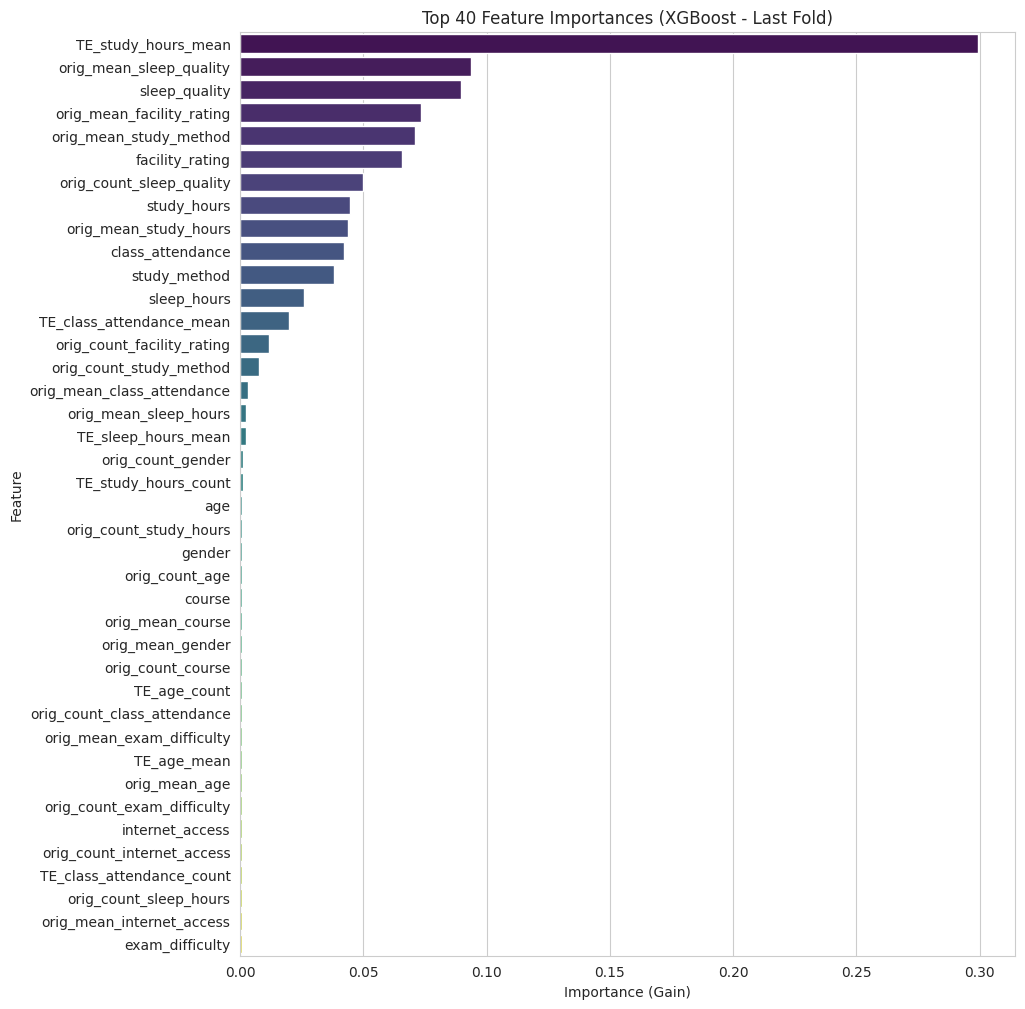

In [ ]:
# Extract importances from the last trained model
# (Note: Ideally we average importances across all folds, but the last fold serves as a good proxy for a baseline)
imp_df = pd.DataFrame({
    'Feature': last_X_train.columns,
    'Importance': last_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(data=imp_df.head(40), x='Importance', y='Feature', palette='viridis')
plt.title('Top 40 Feature Importances (XGBoost - Last Fold)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.show()

# 5. Submission

Submission and OOF files saved successfully.
Submission Shape: (270000, 2)


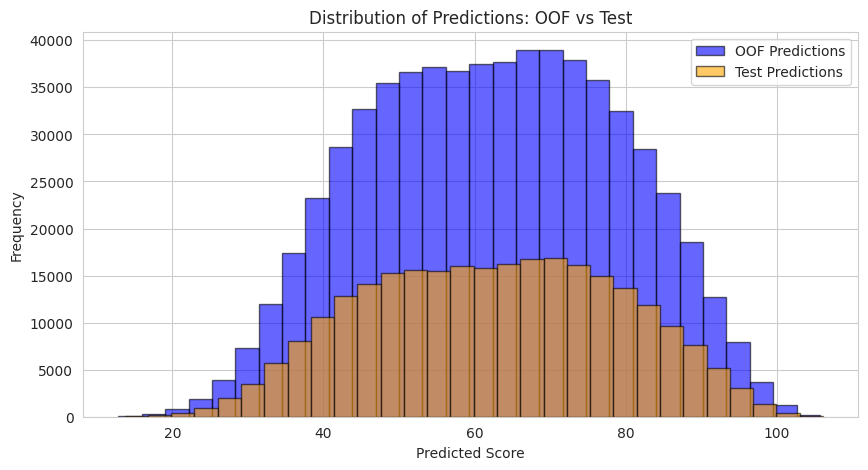

,id,exam_score
0,630000,70.131329
1,630001,68.756254
2,630002,89.444195
3,630003,55.185930
4,630004,45.270959


In [18]:
sub = pd.read_csv('/kaggle/input/playground-series-s6e1/sample_submission.csv')
sub[TARGET] = test_preds
sub.to_csv('submission.csv', index=False)

oof_df = pd.DataFrame()
oof_df['id'] = train['id']
oof_df[TARGET] = y
oof_df['pred'] = oof_preds
oof_df.to_csv('oof_predictions.csv', index=False)

print('Submission and OOF files saved successfully.')
print(f'Submission Shape: {sub.shape}')

plt.figure(figsize=(10, 5))
plt.hist(oof_df['pred'], bins=30, alpha=0.6, label='OOF Predictions', color='blue', edgecolor='black')
plt.hist(sub[TARGET], bins=30, alpha=0.6, label='Test Predictions', color='orange', edgecolor='black')
plt.title('Distribution of Predictions: OOF vs Test')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sub.head()

# huge thanks to @masayakawamata        for his notebook : https://www.kaggle.com/code/masayakawamata/s5e12-eda-xgb-competition-starter